In [22]:
import torch
import torch.nn as nn
from sinabs.backend.dynapcnn import DynapcnnNetworkGraph
from sinabs.layers import Merge, IAFSqueeze
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
channels = 2
height = 34
width = 34

input_shape = (channels, height, width)

## Network Module

We need to define a `nn.Module` implementing the network we want the chip to reproduce.

In [4]:
class SNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, 2, 1, bias=False) # node 0
        self.iaf1 = IAFSqueeze(batch_size=1)            # node 1
        self.pool1 = nn.AvgPool2d(3,3)                  # node 2
        self.pool1a = nn.AvgPool2d(4,4)                 # node 3

        self.conv2 = nn.Conv2d(10, 10, 4, 1, bias=False)# node 4
        self.iaf2 = IAFSqueeze(batch_size=1)            # node 6
        # self.pool2 = nn.AvgPool2d(3,3)                  # node 7

        self.conv3 = nn.Conv2d(10, 1, 2, 1, bias=False) # node 8
        self.iaf3 = IAFSqueeze(batch_size=1)            # node 9

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(49, 500, bias=False)       # node 10
        self.iaf4 = IAFSqueeze(batch_size=1)            # node 11
        
        self.fc2 = nn.Linear(500, 10, bias=False)       # node 12
        self.iaf5 = IAFSqueeze(batch_size=1)            # node 13

        self.adder = Merge()

    def forward(self, x):
        
        con1_out = self.conv1(x)
        iaf1_out = self.iaf1(con1_out)
        pool1_out = self.pool1(iaf1_out)
        pool1a_out = self.pool1a(iaf1_out)

        conv2_out = self.conv2(pool1_out)
        iaf2_out = self.iaf2(conv2_out)
        # pool2_out = self.pool2(iaf2_out)

        conv3_out = self.conv3(self.adder(pool1a_out, iaf2_out))
        iaf3_out = self.iaf3(conv3_out)

        flat_out = self.flat(iaf3_out)
        
        fc1_out = self.fc1(flat_out)
        iaf4_out = self.iaf4(fc1_out)
        fc2_out = self.fc2(iaf4_out)
        iaf5_out = self.iaf5(fc2_out)

        return iaf5_out

In [5]:
snn = SNN()

The following exemplifies how each of the layers in the SNN should be grouped together to form a `DynapcnnLayer` instance. Let's check the shapes of the tensors each of the (original) layers in the model inputs and outputs by feeding a fake input through the model:

In [6]:
x = torch.randn((1, *input_shape))

print(f'DynapcnnLayer 0:                                ... {list(x.shape)}')
con1_out = snn.conv1(x)
print(f'                                                conv1: {list(con1_out.shape)}')
iaf1_out = snn.iaf1(con1_out)
print(f'                                                iaf1: {list(iaf1_out.shape)}')
pool1_out = snn.pool1(iaf1_out)
print(f'                                                pool1: {list(pool1_out.shape)}')
pool1a_out = snn.pool1a(iaf1_out)
print(f'                                                pool1a: {list(pool1a_out.shape)}\n')

print(f'DynapcnnLayer 1:                                ... {list(pool1_out.shape)}')
conv2_out = snn.conv2(pool1_out)
print(f'                                                conv2: {list(conv2_out.shape)}')
iaf2_out = snn.iaf2(conv2_out)
print(f'                                                iaf2: {list(iaf2_out.shape)}\n')
# pool2_out = snn.pool2(iaf2_out)
# print(f'                                                pool2: {list(pool2_out.shape)}\n')

added = snn.adder(pool1a_out, iaf2_out)

print(f'DynapcnnLayer 2:                                ... {list(added.shape)} [ Merge(pool1a, iaf2_out) ]')
conv3_out = snn.conv3(added)
print(f'                                                conv3: {list(conv3_out.shape)}')
iaf3_out = snn.iaf3(conv3_out)
print(f'                                                iaf3: {list(iaf3_out.shape)}\n')

flat_out = snn.flat(iaf3_out)

print(f'DynapcnnLayer 3:                                ... {list(flat_out.shape)}')
fc1_out = snn.fc1(flat_out)
print(f'                                                fc1: {list(fc1_out.shape)}')
iaf4_out = snn.iaf4(fc1_out)
print(f'                                                iaf4: {list(iaf4_out.shape)}\n')


print(f'DynapcnnLayer 4:                                ... {list(iaf4_out.shape)}')
fc2_out = snn.fc2(iaf4_out)
print(f'                                                fc2: {list(fc2_out.shape)}')
iaf5_out = snn.iaf5(fc2_out)
print(f'                                                iaf5: {list(iaf5_out.shape)}\n')

DynapcnnLayer 0:                                ... [1, 2, 34, 34]
                                                conv1: [1, 10, 33, 33]
                                                iaf1: [1, 10, 33, 33]
                                                pool1: [1, 10, 11, 11]
                                                pool1a: [1, 10, 8, 8]

DynapcnnLayer 1:                                ... [1, 10, 11, 11]
                                                conv2: [1, 10, 8, 8]
                                                iaf2: [1, 10, 8, 8]

DynapcnnLayer 2:                                ... [1, 10, 8, 8] [ Merge(pool1a, iaf2_out) ]
                                                conv3: [1, 1, 7, 7]
                                                iaf3: [1, 1, 7, 7]

DynapcnnLayer 3:                                ... [1, 49]
                                                fc1: [1, 500]
                                                iaf4: [1, 500]

DynapcnnLayer 4:            

## DynapcnnNetwork Class

In the constructor of `DynapcnnNetworkGraph` the SNN passed as argument (defined as a `nn.Module`) will be parsed such that each layer is represented in a computational graph (using `nirtorch.extract_torch_graph`). 

The layers are the `nodes` of the graph, while their connectivity (how the outputs from a layer are sent to other layers) is represented as `edges`, represented in a `list` of `tuples`.

Once the constructor finishes its initialization, the `hw_model.dynapcnn_layers` property is a dictionary where each entry represents the ID of a `DynapcnnLayer` instance (an `int` from `0` to `L`), with this entry containing a `DynapcnnLayer` instance where a subset of the layers in the original SNN has been incorporated into, the core such instance has been assigned to, and the list of `DynapcnnLayer` instances (their IDs) the layer targets.

In [7]:
hw_model = DynapcnnNetworkGraph(
    snn,
    discretize=True,
    input_shape=input_shape
)

The `hw_model.to()` call will figure out into which core eac `DynapcnnLayer` instance will be assigned to. Once this assingment is made the instance itself is used to configure the `CNNLayerConfig` instance representing the core's configuration.

If the cores' configuration is valid, each `DynapcnnLayer` instance and their respective destinations will be used to create a computational graph that encodes how the `forward` method of `hw_model.network` (a `nn.Module` using the `DynapcnnLayer` instances) propagates that through the network.

In [8]:
hw_model.to(device="speck2fmodule:0")

Network is valid


The layers comprising our `hw_model` and their respective metadata can be inspected by calling `print` on a `DynapcnnNetworkGraph` instance.

In [9]:
print(hw_model)

---- DynapcnnLayer 0 ----------------------------------------------------------
> layer modules: 
(node 0): Conv2d(2, 10, kernel_size=(2, 2), stride=(1, 1), bias=False)
(node 1): IAFSqueeze(spike_threshold=Parameter containing:
tensor(1.), min_v_mem=Parameter containing:
tensor(-32768.), batch_size=1, num_timesteps=-1)
(node 2): SumPool2d(norm_type=1, kernel_size=(3, 3), stride=None, ceil_mode=False)
(node 3): SumPool2d(norm_type=1, kernel_size=(4, 4), stride=None, ceil_mode=False)
> layer destinations: [1, 2]
> assigned core: 0

---- DynapcnnLayer 1 ----------------------------------------------------------
> layer modules: 
(node 4): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
(node 6): IAFSqueeze(spike_threshold=Parameter containing:
tensor(1.), min_v_mem=Parameter containing:
tensor(-32768.), batch_size=1, num_timesteps=-1)
> layer destinations: [2]
> assigned core: 1

---- DynapcnnLayer 2 ----------------------------------------------------------
> layer modules:

## Training our DynapcnnNetwork

Preparing the data...

In [10]:
# https://synsense.gitlab.io/sinabs-dynapcnn/getting_started/notebooks/nmnist_quick_start.html

from tonic.datasets.nmnist import NMNIST
from tonic.transforms import ToFrame
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from tqdm.notebook import tqdm
    
# download dataset
root_dir = "./NMNIST"
_ = NMNIST(save_to=root_dir, train=True)
_ = NMNIST(save_to=root_dir, train=False)

In [11]:
sample_data, label = NMNIST(save_to=root_dir, train=False)[0]

print(f"type of data is: {type(sample_data)}")
print(sample_data.shape)
print(f"time length of sample data is: {sample_data['t'][-1] - sample_data['t'][0]} micro seconds")
print(f"there are {len(sample_data)} events in the sample data")
print(f"the label of the sample data is: {label}")

type of data is: <class 'numpy.ndarray'>
(4686,)
time length of sample data is: 300760 micro seconds
there are 4686 events in the sample data
the label of the sample data is: 5


In [12]:
n_time_steps = 50
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)

snn_train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_raster)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)

# check the transformed data
sample_data, label = snn_train_dataset[0]
print(f"The transformed array is in shape [Time-Step, Channel, Height, Width] --> {sample_data.shape}")

The transformed array is in shape [Time-Step, Channel, Height, Width] --> (50, 2, 34, 34)


Setting the training hyperparameters...

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA GeForce RTX 3070 Ti


In [14]:
epochs = 1
lr = 1e-4
batch_size = 64
num_workers = 4
shuffle = True

In [15]:
snn_train_dataloader = DataLoader(snn_train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

Initializing our weights...

In [16]:
hw_cnn = hw_model.network

In [17]:
hw_cnn.to(device)

In [18]:
hw_cnn.init_weights()

In [19]:
optimizer = SGD(params=hw_cnn.parameters(), lr=lr)
criterion = CrossEntropyLoss()

The training loop...

In [20]:
losses = []
batches = []
batch_count = 0

In [21]:
for e in range(epochs):

    # train
    train_p_bar = tqdm(snn_train_dataloader)
    for data, label in train_p_bar:
        # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
        data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        optimizer.zero_grad()
        output = hw_cnn(data)
        # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
        output = output.reshape(batch_size, n_time_steps, -1)
        # accumulate all time-steps output for final prediction
        output = output.sum(dim=1)
        loss = criterion(output, label)
        # backward
        loss.backward()
        optimizer.step()
        
        # detach the neuron states and activations from current computation graph(necessary)
        hw_cnn.detach_neuron_states()
        
        # set progressing bar
        train_p_bar.set_description(f"Epoch {e} - BPTT Training Loss: {round(loss.item(), 4)}")

        batch_count += 1
        losses.append(loss.item())
        batches.append(batch_count)

    # validate
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(snn_test_dataloader)
        for data, label in test_p_bar:
            # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
            data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
            label = label.to(dtype=torch.long, device=device)
            # forward
            output = hw_cnn(data)
            # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
            output = output.reshape(batch_size, n_time_steps, -1)
            # accumulate all time-steps output for final prediction
            output = output.sum(dim=1)
            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            # compute the total correct predictions
            correct_predictions.append(pred.eq(label.view_as(pred)))
            # set progressing bar
            test_p_bar.set_description(f"Epoch {e} - BPTT Testing Model...")
    
        correct_predictions = torch.cat(correct_predictions)
        print(f"Epoch {e} - BPTT accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 0 - BPTT accuracy: 11.818910256410255%


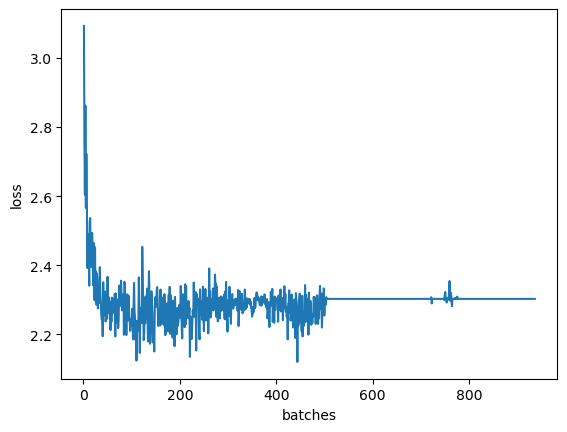

In [24]:
plt.plot(batches, losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()